# Water quality
![](img/NKN_20250912_184806.JPG)

{octicon}`calendar` Sep, 2025 

{bdg-primary-line}`Data Analysis`

## Background
Within the [open data catalog](https://opendata.euskadi.eus/) of the Basque Government, there is an API available to access information on drinking water ([Drinking Water Quality API](https://opendata.euskadi.eus/api-drinking-water/?api=drinkingwater-quality)), and I thought it might be interesting to take a look at it to see whether it could be useful to know something about the water that comes out of our taps.

After exploring the parameter data a bit, I realized that the analysis I should carry out in this project was not so much about interpreting what those data meant (since I lack expertise in the subject), but rather about making a comparison between the values obtained from different measurement points. I decided to compare the water in my hometown, which reaches my house, with that from the largest reservoir in the capital, San Sebastián, which supplies most of the city. This way, I might be able to draw some comparative conclusions about the characteristics of the water.

## The data
I wrote some helper classes and functions to:
1. Retrieve the available __sampling points__ for a given municipality.
2. Retrieve the available __measurements__ for a specific sampling point.
3. Retrieve the __analytical data__ obtained in a measurement.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Class for this project
from wq_api import WaterQuality

# Instantiate object to access API
wq = WaterQuality()

# Function definition
def sampling_points(county_id, municipality_id, itemsOfPage=100):
    '''Return dataframe with sampling points for municipality.
    '''
    spoints = wq.find_sampling_points(county_id, municipality_id, itemsOfPage=100)

    ids = [item["id"] for item in spoints["items"]]
    names = [item["name"] for item in spoints["items"]]
    zones = [item["location"]["zone"] for item in spoints["items"]]
    
    lenghts, mdates, qcodes = [], [], []
    for id_ in ids:
        measurements = wq.get_measurements(id_)
        lenghts.append(len(measurements))
        dates, codes = [], []
        for measurement in measurements:
            dates.append(measurement["measurementDate"])
            codes.append(measurement["qualificationCode"])
        mdates.append(dates)
        qcodes.append(codes)
    
    points = pd.DataFrame({"id": ids,
                           "name": names,
                           "zone": zones,
                           "measurements": lenghts,
                           "dates": mdates,
                           # "codes": qcodes,
                          })
    
    return points.sort_values(by="measurements", ascending=False)

# Function definition
def dates(point_id, points_df):
    '''Return list of available sampling dates.
    '''
    return list(points_df.loc[points_df["id"] == int(point_id), "dates"])[0]

# Function definition
def analytical_data(point_id, dates):
    '''Return dataframe with available analytical data for sample point.
    '''
    dfs = []
    for date in dates:
        params, values = [], []
        for item in wq.get_analytical_data(point_id, date):
            params.append(item["parameter"] + " (" + item["unitOfMeasure"] + ")")
            values.append(item["value"])
        dfs.append(pd.DataFrame({date: values}, index=params))
    
    return pd.concat(dfs, axis=1)

Get municipality ids for Urretxu and San Sebastian:

In [2]:
municipality_ids = pd.read_csv("data/gipuzkoa_ids.csv", index_col="municipality")

urretxu_id = municipality_ids.loc["Urretxu", "id"]
ss_id = municipality_ids.loc["Donostia / San Sebastián", "id"]

print("Municipality ids:")
print(f"- Urretxu -> {urretxu_id}")
print(f"- Donostia / San Sebastián -> {ss_id}")

Municipality ids:
- Urretxu -> 77
- Donostia / San Sebastián -> 69


In [3]:
points_ur = sampling_points(county_id="20", # Gipuzkoa
                            municipality_id=urretxu_id)
print("SAMPLING POINTS FOR URRETXU:")
points_ur

SAMPLING POINTS FOR URRETXU:


,id,name,zone,measurements,dates
5,20032077004,ERRATZU DEPOSITOA IRTEERA,BARRENDIOLA,31,"[2025-03-18, 2025-02-18, 2025-02-04, 2024-12-1..."
6,20032077005,ETXABURU DEPOSITOA IRTEERA,BARRENDIOLA,5,"[2025-01-28, 2024-12-17, 2024-02-15, 2023-12-1..."
9,20066077001,ERRATZU INDUSTRIALDEA,URRETXU-ZULOAGA,4,"[2025-02-18, 2024-12-17, 2024-01-31, 2023-03-16]"
4,20032077003,IPIÑARRIETA KALEA,BARRENDIOLA,3,"[2025-03-18, 2024-02-28, 2023-03-28]"
1,20066077000,ZULOAGA DEPOSITOA IRTEERA,URRETXU-ZULOAGA,2,"[2024-08-20, 2023-08-16]"
2,20032077001,MUNDO MEJOR,BARRENDIOLA,2,"[2024-06-26, 2023-07-05]"
0,20032077000,IPARRAGIRRE KALEA,BARRENDIOLA,1,[2023-03-16]
3,20032077002,GERNIKAKO ARBOLA,BARRENDIOLA,1,[2023-03-22]
7,20032077006,INSTITUTO IPARRAGIRRE,BARRENDIOLA,1,[2023-03-21]
8,20032077007,CEMENTERIO,BARRENDIOLA,1,[2023-04-27]


Urretxu has two different drinking water zones: the main one, supplied by the Barrendiola reservoir, and another serving rural areas at higher elevations than the local reservoirs fed by Barrendiola. The main sampling point—with the largest number of measurements—is located at the Erratzu local reservoir, a 1,600 m³ tank that supplies the entire town.

In [4]:
points_ss = sampling_points(county_id="20", # Gipuzkoa
                            municipality_id=ss_id)
print("SAMPLING POINTS FOR DONOSTIA / SAN SEBASTIÁN:")
points_ss

SAMPLING POINTS FOR DONOSTIA / SAN SEBASTIÁN:


,id,name,zone,measurements,dates
69,20134069143,DPT. AMARA,AÑARBE,44,"[2024-12-27, 2024-11-22, 2024-11-08, 2024-10-2..."
0,20134069000,Depósito de Putzueta,AÑARBE,42,"[2025-01-03, 2024-12-18, 2024-11-19, 2024-11-0..."
77,20134069153,Deposito ORIABENTA Nuevo - Salida,AÑARBE,40,"[2024-12-27, 2024-12-13, 2024-11-22, 2024-11-0..."
1,20134069100,DEPOSITO MATIA,AÑARBE,39,"[2024-12-17, 2024-11-18, 2024-11-05, 2024-10-2..."
17,20134069038,DPT. MONS,AÑARBE,39,"[2024-12-19, 2024-11-21, 2024-10-24, 2024-10-1..."
...,...,...,...,...,...
47,20134069114,Polígono Zuatzu,AÑARBE,0,[]
46,20134069113,FEDERICO GARCIA LORCA,AÑARBE,0,[]
34,20134069086,ZONA ALTA LOIOLA,AÑARBE,0,[]
35,20134069087,ZABALEGUI,AÑARBE,0,[]


Amara is the main reservoir in San Sebastián, with a capacity of 26,000 m³—about 16 times larger than Urretxu’s largest reservoir, Erratzu.

For the comparison, I will use the available analytical data from:
- __Erratzu__ (20032077004), in Urretxu
- __Amara__ (20134069143), in Donostia / San Sebastián

In [5]:
erratzu = "20032077004"
data_erratzu = analytical_data(point_id=erratzu,
                               dates=dates(erratzu, points_ur),
                              )
print("ANALYTICAL DATA IN ERRATZU (URRETXU):")
data_erratzu

ANALYTICAL DATA IN ERRATZU (URRETXU):


,2025-03-18,2025-02-18,2025-02-04,2024-12-17,2024-11-20,2024-11-12,2024-11-06,2024-10-22,2024-09-25,2024-08-20,...,2023-06-20,2023-06-14,2023-05-15,2023-04-24,2023-03-28,2023-03-22,2023-03-16,2023-03-13,2023-02-13,2023-01-23
AMONIO (mg/l),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.05,0.05,...,0.05,0.10,0.10,0.10,0.05,0.05,0.05,0.1,0.10,0.10
CLORO LIBRE RESIDUAL (mg/l),0.43,0.59,0.56,0.39,0.37,0.33,0.39,0.43,0.35,0.33,...,0.42,0.69,0.81,0.83,0.54,0.48,0.47,0.8,0.75,0.85
COLIFORMES TOTALES (ufc/100 ml),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
COLOR (Pt/Co) (mg/l),0.00,0.00,0.00,0.00,0.00,0.00,7.00,4.00,4.00,4.00,...,4.00,5.00,5.00,5.00,4.00,4.00,4.00,5.0,5.00,5.00
CONDUCTIVIDAD (20ºC) (µs/cm),123.00,118.00,117.00,121.00,136.00,130.00,133.00,142.00,140.00,129.00,...,136.00,130.00,124.00,123.00,122.00,122.00,122.00,120.0,119.00,121.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SULFATO (mg/l),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.00,NaN,NaN,NaN
TETRACLOROETENO (µg/l),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN
TRICLOROETENO (µg/l),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN
TRICLOROETENO+TETRACLOROETENO (µg/l),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN


In [6]:
amara = "20134069143"
data_amara = analytical_data(point_id=amara,
                             dates=dates(amara, points_ss),
                            )
print("ANALYTICAL DATA IN AMARA (DONOSTIA / SAN SEBASTIÁN):")
data_amara

ANALYTICAL DATA IN AMARA (DONOSTIA / SAN SEBASTIÁN):


,2024-12-27,2024-11-22,2024-11-08,2024-10-25,2024-09-27,2024-09-16,2024-08-23,2024-07-26,2024-06-28,2024-06-14,...,2023-05-26,2023-05-05,2023-04-28,2023-04-14,2023-03-24,2023-03-10,2023-02-24,2023-02-10,2023-01-27,2023-01-13
ALCALINIDAD (HC03) (mg/l),47.40,44.40,45.50,40.50,45.10,41.80,47.20,43.90,42.30,43.20,...,39.700,44.80,47.80,49.20,49.90,50.00,44.80,47.10,47.80,42.80
ALUMINIO (µg/l),34.00,49.50,54.30,43.40,53.20,50.30,50.30,52.50,40.10,42.80,...,34.500,24.80,40.50,31.90,39.50,27.50,33.00,32.00,33.00,37.00
CALCIO (mg/l),20.70,20.00,20.00,18.90,19.30,17.50,19.30,18.90,19.10,19.40,...,18.600,19.50,19.90,21.70,20.80,21.80,19.20,20.30,20.80,18.10
CLORO LIBRE RESIDUAL (mg/l),0.65,0.66,0.61,0.67,0.59,0.49,0.62,0.68,0.59,0.65,...,0.810,0.77,0.75,0.76,0.71,0.68,0.66,0.61,0.70,0.55
COLIFORMES TOTALES (ufc/100 ml),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
COLOR (Pt/Co) (mg/l),0.00,0.00,0.00,0.00,3.00,3.00,3.00,3.00,3.00,3.00,...,3.000,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00,3.00
CONDUCTIVIDAD (20ºC) (µs/cm),131.00,127.00,129.00,122.00,122.00,118.00,124.00,119.00,119.00,119.00,...,127.000,123.00,126.00,131.00,134.00,131.00,135.00,130.00,137.00,122.00
DUREZA TOTAL CALCIO (CaCO3) (mg/l),58.00,56.00,56.00,53.00,53.00,49.00,54.00,52.00,53.00,53.00,...,52.000,54.00,55.00,59.00,57.00,60.00,53.00,56.00,57.00,51.00
ENTEROCOCOS (ufc/100 ml),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESCHERICHIA COLI (ufc/100 ml),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Data analysis
### Available parameters
Let's first get a comparative view of available parameters and the number of times they were sampled in each of the reservoirs:

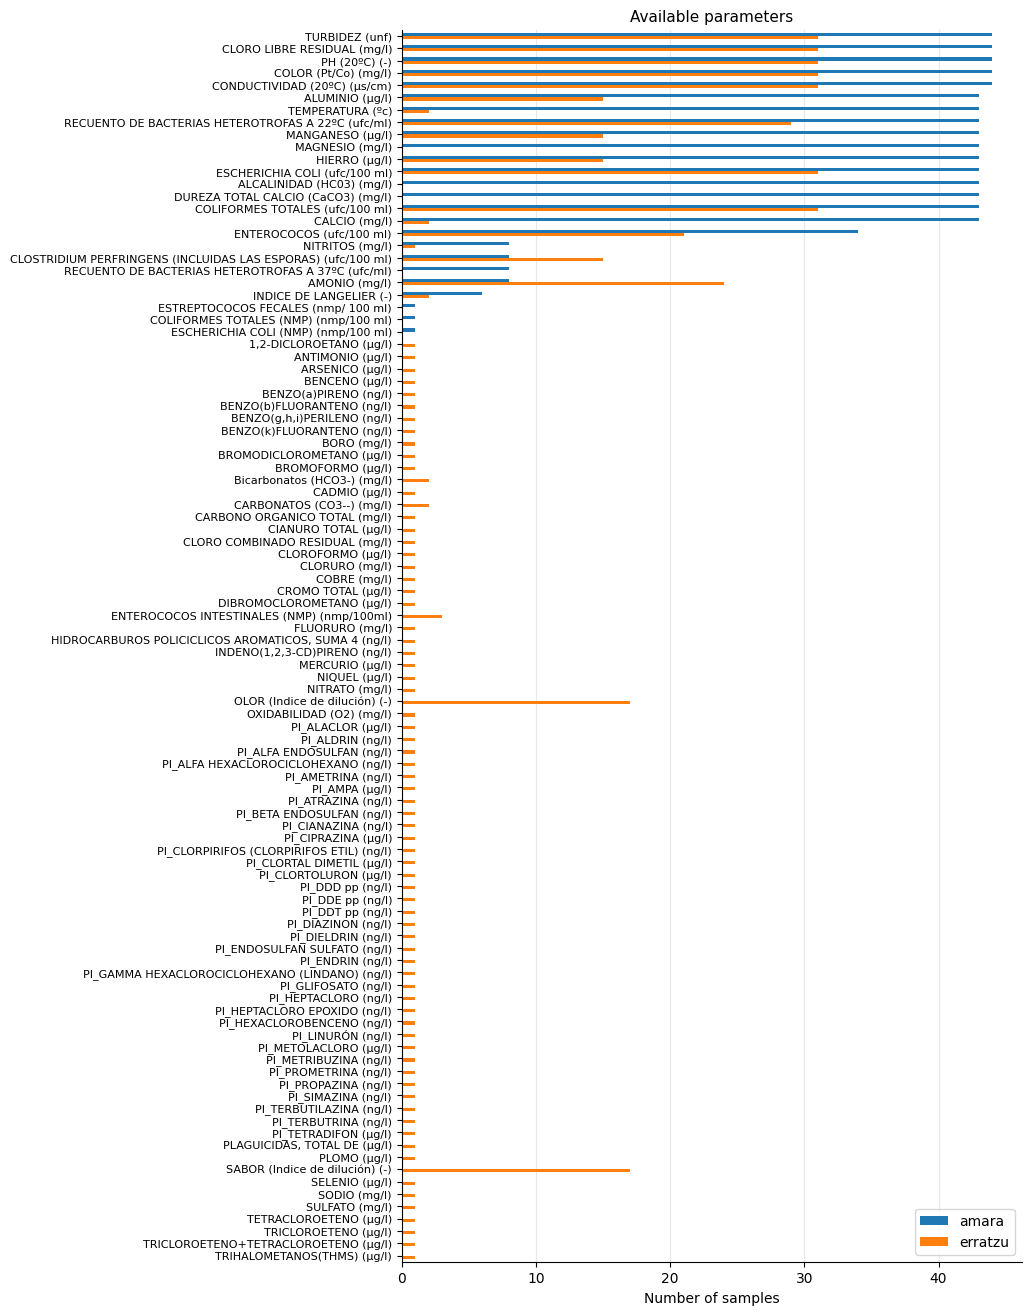

In [7]:
# Compute each parameter quantities
samples_erratzu = data_erratzu.notna().sum(axis=1)
samples_erratzu = samples_erratzu.sort_values(ascending=False).to_frame(name="erratzu")

samples_amara = data_amara.notna().sum(axis=1)
samples_amara = samples_amara.sort_values(ascending=False).to_frame(name="amara")

# Get all of them in one dataframe
samples_all = samples_amara.join(samples_erratzu, how="outer")
samples_all = samples_all.sort_values("amara", ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(8, 16))
samples_all.plot(ax=ax, kind="barh")
ax.invert_yaxis()
ax.grid(axis="x", alpha=0.3)
ax.set_axisbelow(True)
ax.set_title("Available parameters", size=11)
ax.set_xlabel("Number of samples")
ax.tick_params(axis='y', labelsize=8, rotation=0)
sns.despine()
plt.show()

The available measurements for Amara appear more consistent in the parameters that are regularly monitored. In Erratzu, there was one measurement where many parameters were sampled, but it occurred only once.

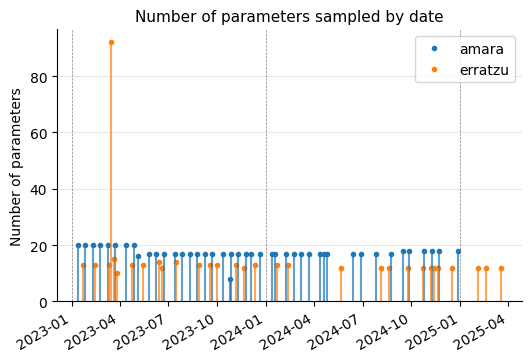

In [8]:
# Compute number of parameters sampled by date
dates_erratzu = data_erratzu.notna().sum()
dates_erratzu = dates_erratzu.sort_index().to_frame(name="erratzu")

dates_amara = data_amara.notna().sum()
dates_amara = dates_amara.sort_index().to_frame(name="amara")

# Get all of them in one dataframe
dates_all = dates_amara.join(dates_erratzu, how="outer")
dates_all.index = pd.to_datetime(dates_all.index)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(dates_all.index, dates_all["amara"], ".", label="amara")
ax.plot(dates_all.index, dates_all["erratzu"], ".", label="erratzu")
ax.vlines(dates_all.index, ymin=0, ymax=dates_all["amara"], linestyle="-", alpha=0.7)
ax.vlines(dates_all.index, ymin=0, ymax=dates_all["erratzu"], linestyle="-", alpha=0.7,
          color=sns.color_palette("tab10")[1])
ax.grid(axis="y", alpha=0.3)
ax.set_axisbelow(True)
ax.set_ylim(0)
ax.set_title("Number of parameters sampled by date", size=11)
ax.set_ylabel("Number of parameters")
for i in range(2023, 2026):
    ax.axvline(pd.to_datetime(str(i)), linestyle="--", color="grey", linewidth=0.5)
fig.autofmt_xdate()
ax.legend()
sns.despine()
plt.show()

As we can see, data is available from 2023 onward, and lately the frequency of measurements (or at least the data provided through the API) appears to be more limited. Typically, more parameters are measured in Amara than in Erratzu.  
The graph also clearly shows that, in Erratzu, there was one occasion (__2023-03-16__) where a large number of parameters were sampled. Is this an indication than some parameters where found to be out of range previously? I will show this date in the following graphs as a vertical line for reference.

### Comparison
As mentioned earlier, this project will focus solely on a comparative analysis, so I will only plot parameters that have been sampled in both reservoirs at least once.

In [9]:
# Perform an inner merge to get parameters in both
samples_both = samples_amara.join(samples_erratzu, how="inner")
samples_both

,amara,erratzu
TURBIDEZ (unf),44,31
CLORO LIBRE RESIDUAL (mg/l),44,31
COLOR (Pt/Co) (mg/l),44,31
CONDUCTIVIDAD (20ºC) (µs/cm),44,31
PH (20ºC) (-),44,31
ALUMINIO (µg/l),43,15
TEMPERATURA (ºc),43,2
RECUENTO DE BACTERIAS HETEROTROFAS A 22ºC (ufc/ml),43,29
MANGANESO (µg/l),43,15
HIERRO (µg/l),43,15


In [10]:
# Subset dataframe with data for common parameters
data_amara_common = data_amara[data_amara.index.isin(samples_both.index)]
data_amara_common_t = data_amara_common.transpose().sort_index()
data_amara_common_t.index = pd.to_datetime(data_amara_common_t.index)

data_erratzu_common = data_erratzu[data_erratzu.index.isin(samples_both.index)]
data_erratzu_common_t = data_erratzu_common.transpose().sort_index()
data_erratzu_common_t.index = pd.to_datetime(data_erratzu_common_t.index)

# Define plot function
def plot_params(params):
    for param in params:
        fig, ax = plt.subplots(figsize=(6, 4))
        data_amara_common_t[[param]].plot(ax=ax, marker=".", linewidth=0.5)
        data_erratzu_common_t[[param]].plot(ax=ax, marker=".", linewidth=0.5)
        ax.grid(axis="both", alpha=0.3)
        ax.set_axisbelow(True)
        ax.set_title(param, size=10)
        fig.autofmt_xdate()
        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=h, labels=["amara", "erratzu"])
        ax.axvline("2023-03-16", linestyle="--", color="grey", linewidth=0.5)
        sns.despine()
        plt.show()

#### _Parámetros Físicos y Organolépticos_
_Estos afectan la apariencia, sabor y olor del agua, más que la salud directa (aunque altos niveles pueden indicar problemas subyacentes). Interesantes si el agua "no parece potable" (ej. turbia o con mal olor)._

|Parámetro|Descripción|Rango indicado para consumo humano|
|--|--|--|
|__PH (20ºC)__|Mide acidez/alcalinidad; afecta corrosión y sabor.|Ideal 6.5-9.5; fuera de rango puede indicar contaminación o problemas en tratamiento.|
|__COLOR (Pt/Co)__|Indica impurezas orgánicas o minerales.|Debe ser bajo (<5 Pt/Co) para aceptabilidad; alto puede ser inofensivo pero desagradable.|
|__TURBIDEZ__|Mide claridad; alto puede ocultar patógenos.|<1 NTU para desinfección efectiva y estética.|
|__TEMPERATURA__|Afecta crecimiento bacteriano y sabor.|<25ºC es preferible para consumo.|

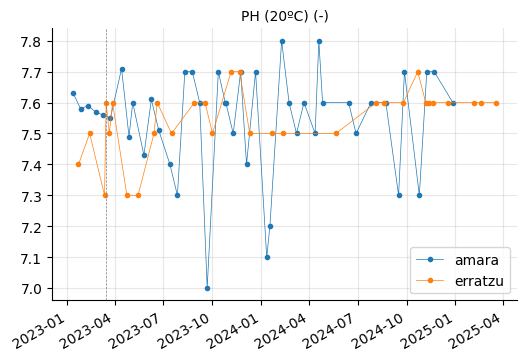

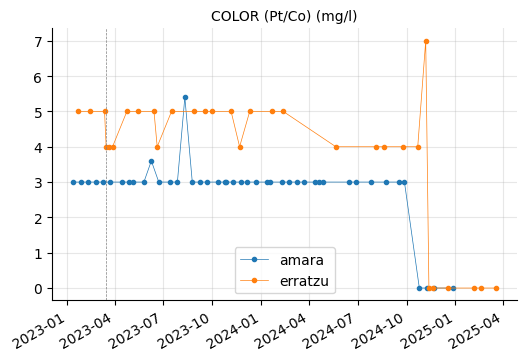

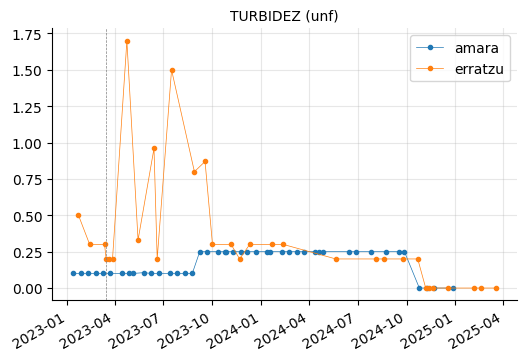

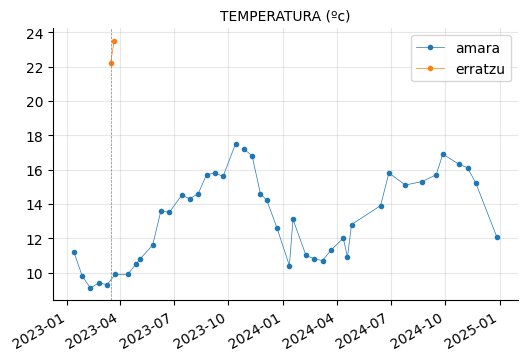

In [11]:
params_1 = ["PH (20ºC) (-)",
            "COLOR (Pt/Co) (mg/l)",
            "TURBIDEZ (unf)",
            "TEMPERATURA (ºc)"]

plot_params(params_1)

Erratzu appears to have had issues with COLOR and TURBIDEZ, although these parameters seem to have returned to normal in the most recent measurements.

#### _Parámetros Químicos Inorgánicos y Metales_
_Estos miden sales, metales y nutrientes. Interesantes para estudiar dureza del agua (afecta electrodomésticos) o toxicidad crónica (ej. metales pesados). Muchos tienen límites por salud a largo plazo._

|Parámetro|Descripción|Rango indicado para consumo humano|
|--|--|--|
|__CONDUCTIVIDAD (20ºC)__|Mide sales totales; indica mineralización.|<2500 µS/cm; alto puede sugerir contaminación salina.|
|__AMONIO__|De descomposición orgánica; alto indica contaminación.|<0.5 mg/L; puede formar compuestos tóxicos con cloro.|
|__ALUMINIO / HIERRO / MANGANESO__|Metales de sedimentos o corrosión.|alto aluminio (>0.2 mg/L) o hierro (>0.2 mg/L) afectan salud.|
|__CALCIO / BICARBONATOS (HCO3-) / CARBONATOS (CO3--)__|Componentes de dureza; índice de Langelier evalúa corrosión.|indican si el agua es ""dura"" (puede formar incrustaciones).|
|__NITRATO / NITRITOS__|De fertilizantes; altos causan metahemoglobinemia.|nitrato <50 mg/L, nitritos <0.5 mg/L; críticos para bebés.|

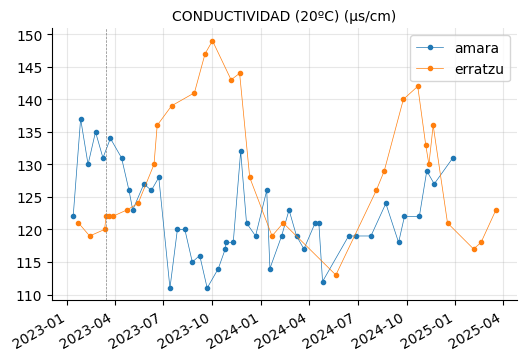

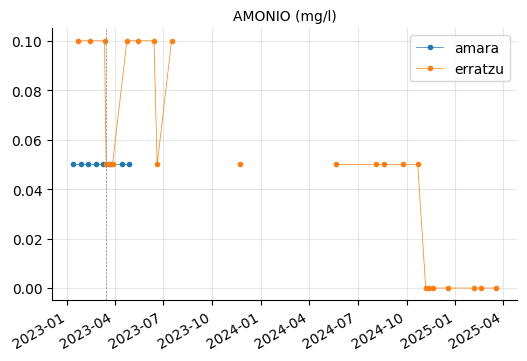

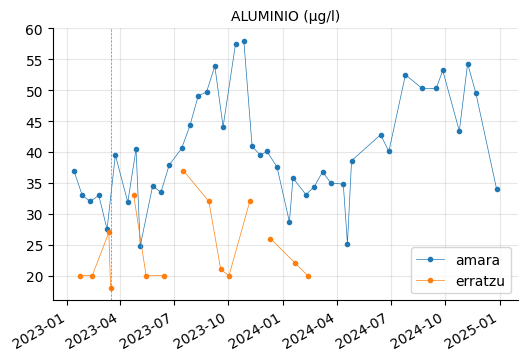

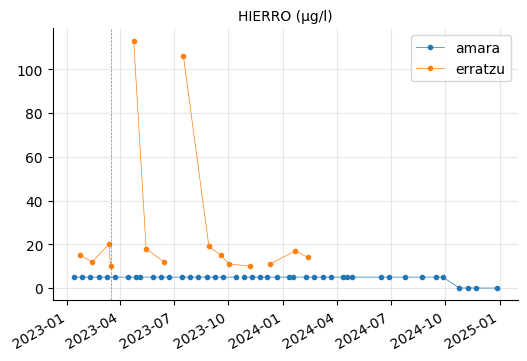

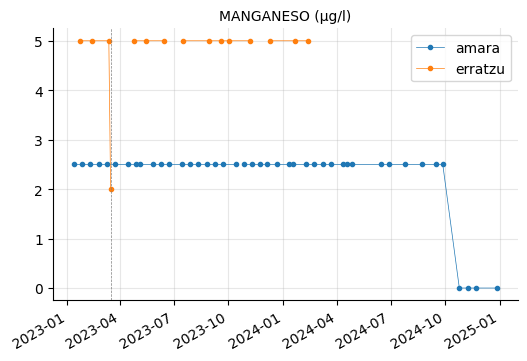

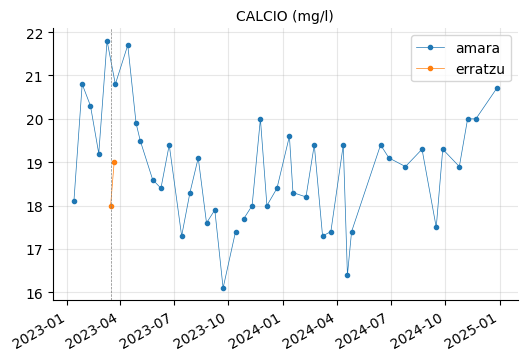

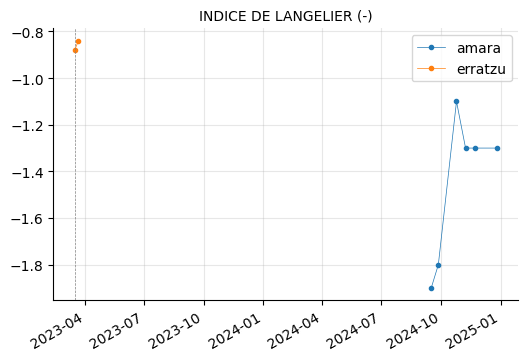

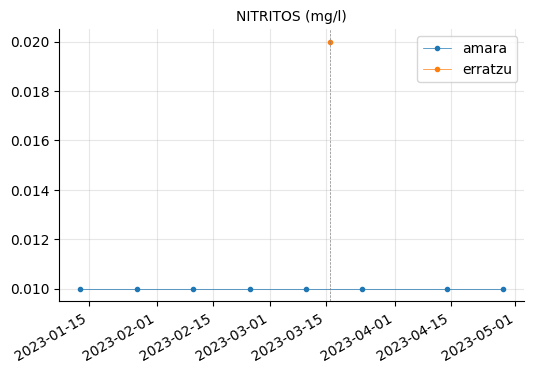

In [12]:
params_2 = ["CONDUCTIVIDAD (20ºC) (µs/cm)",
            "AMONIO (mg/l)",
            "ALUMINIO (µg/l)", "HIERRO (µg/l)", "MANGANESO (µg/l)",
            "CALCIO (mg/l)", "INDICE DE LANGELIER (-)",
            "NITRITOS (mg/l)"]

plot_params(params_2)

_ALUMINIO_, _HIERRO_, and _MANGANESO_ levels tend to vary between the reservoirs, but they do not appear to be out of range.

#### _Parámetros Microbiológicos_
_Estos son críticos porque indican contaminación fecal o patógenos que pueden causar enfermedades. Son esenciales para evaluar si el agua es segura para beber. Interesantes para estudiar si hay sospechas de contaminación (ej. por roturas en tuberías)._

|Parámetro|Descripción|Rango indicado para consumo humano|
|--|--|--|
|__COLIFORMES TOTALES__|Detecta bacterias indicadoras de contaminación.|debe estar ausente o muy bajo; alto nivel sugiere riesgo sanitario.
|__ESCHERICHIA COLI__|Indicador específico de contaminación fecal reciente.|debe ser 0 UFC/100 ml para potabilidad.
|__RECUENTO DE BACTERIAS HETEROTROFAS A 22ºC__|Mide bacterias generales en el agua.|indica estabilidad biológica; alto puede sugerir biofilm en tuberías.
|__ENTEROCOCOS / ENTEROCOCOS INTESTINALES (NMP)__|Indicadores de contaminación fecal resistente.|deben estar ausentes; relacionados con infecciones gastrointestinales.
|__CLOSTRIDIUM PERFRINGENS (INCLUIDAS LAS ESPORAS)__|Detecta contaminación antigua o por suelos.|indicador de tratamiento insuficiente; debe ser 0.

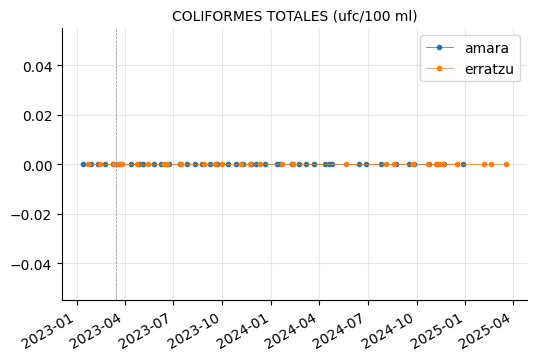

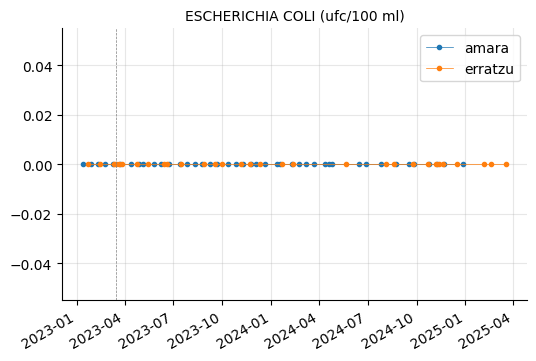

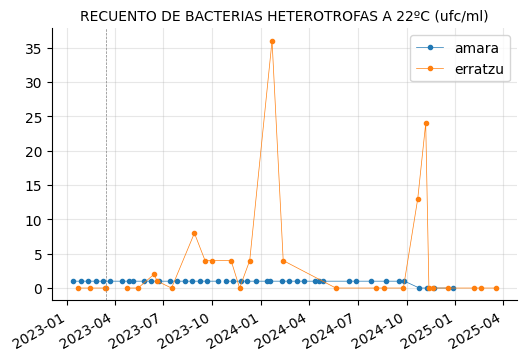

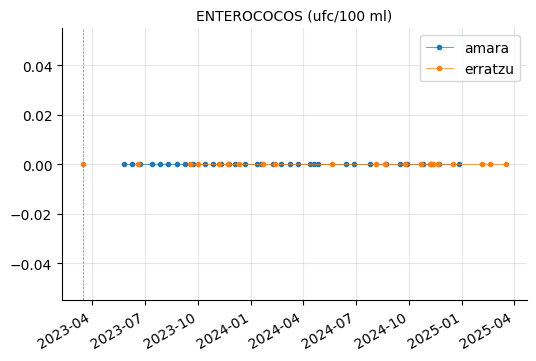

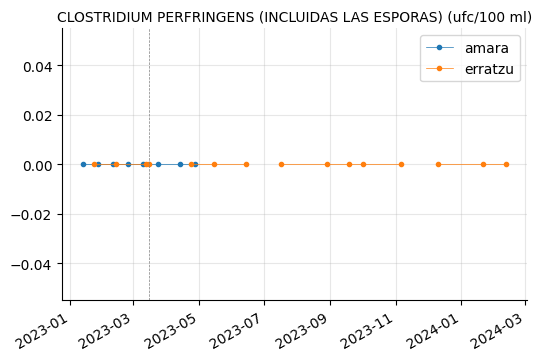

In [13]:
params_3 = ["COLIFORMES TOTALES (ufc/100 ml)",
            "ESCHERICHIA COLI (ufc/100 ml)",
            "RECUENTO DE BACTERIAS HETEROTROFAS A 22ºC (ufc/ml)",
            "ENTEROCOCOS (ufc/100 ml)",
            "CLOSTRIDIUM PERFRINGENS (INCLUIDAS LAS ESPORAS) (ufc/100 ml)"]

plot_params(params_3)

_RECUENTO DE BACTERIAS HETEROTROFAS A 22ºC_ showed a couple of peaks in Erratzu, but the issue seems to have been resolved.

#### _Parámetros Relacionados con Desinfección_
_Estos evalúan el tratamiento (cloración). Interesantes para balancear desinfección vs. subproductos._

|Parámetro|Descripción|Rango indicado para consumo humano|
|--|--|--|
|__CLORO LIBRE RESIDUAL / CLORO COMBINADO RESIDUAL__|Niveles de desinfectante.|0.2-1 mg/L libre; asegura protección bacteriana sin exceso (que causa sabor).|

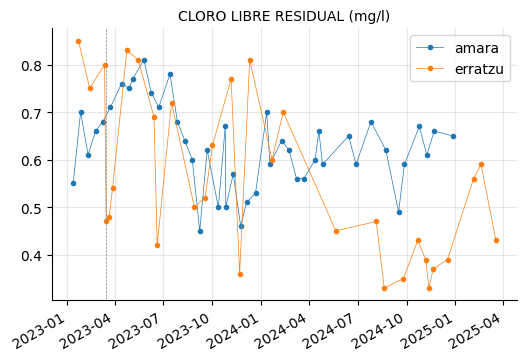

In [14]:
params_4 = ["CLORO LIBRE RESIDUAL (mg/l)"]

plot_params(params_4)

Both are inside recommended range but is there a significant difference in chlorine (_CLORO_) levels between the two reservoirs? Let's plot average values with confidence intervals to check it out.

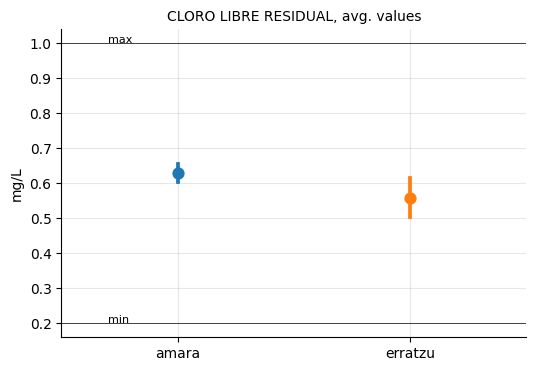

In [15]:
# Subset CLORO
cloro_amara = data_amara_common_t["CLORO LIBRE RESIDUAL (mg/l)"].to_frame("amara")
cloro_erratzu = data_erratzu_common_t["CLORO LIBRE RESIDUAL (mg/l)"].to_frame("erratzu")

# Prepare dataframe for seaborn plotting
cloro = cloro_amara.join(cloro_erratzu, how="outer").melt().dropna()

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(x="variable", y="value", data=cloro, hue="variable")
ax.grid(axis="both", alpha=0.3)
ax.set_axisbelow(True)
ax.set_title("CLORO LIBRE RESIDUAL, avg. values", size=10)
ax.set_xlabel("")
ax.set_ylabel("mg/L")
ax.axhline(1, color="black", linewidth=0.5)
ax.axhline(0.2, color="black", linewidth=0.5)
ax.annotate("max", (-0.3, 1), size=8)
ax.annotate("min", (-0.3, 0.2), size=8)
sns.despine()
plt.show()

On average, the water from Erratzu seems to be slightly less chlorinated than that from Amara, a result strongly influenced by the most recent measurements, where Erratzu’s values were clearly below Amara’s. However, the difference is minimal, and in any case, both are within the recommended range.

## Conclusion
Overall, there do not appear to be significant differences between the characteristics of the drinking water in Erratzu (Urretxu) and Amara (San Sebastián). This is not unexpected, given that although the water originates from different reservoirs (Barrendiola and Añarbe, respectively), the sources are geographically close, and in both cases the water is treated in purification plants before reaching the storage tanks where the measurements were taken.

That said, the scope for comparative analysis is limited by inconsistencies in the selection of analyzed parameters. For example, water hardness is an important parameter, as it affects the lifespan of washing machines and dishwashers and is sometimes necessary to know in order to maintain these appliances properly. While this parameter is consistently measured in Amara, it is not measured in Erratzu. Consequently, it is not included in this study, illustrating the inconsistency in the parameters monitored.